In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import datetime
import random
import torch
from torch.utils.data import DataLoader

from datasets import Dataset
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from sklearn.utils import resample

from transformers import BertForSequenceClassification, BertConfig
from transformers import T5EncoderModel, T5Tokenizer
from sklearn.metrics import f1_score

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
import warnings
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
#pd.options.mode.chained_assignment = None
    
from transformers import BertTokenizer
from tcrbert_mdf import CustomModel, train_per_protein, create_dataset




[2025-05-20 02:13:24,864] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
import os.path
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [3]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [4]:
def add_spaces(seq):
     return ' '.join(list(seq))

    
def save_model(model,filepath):
    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, mod_type='Prottrans', num_labels=1, mixed = False):
    if mod_type=='Prottrans':
        my_model, tokenizer = PT5_classification_model(num_labels=num_labels, half_precision=mixed)
        
    elif mod_type=='TCR-bert':
        # tokenizer = BertTokenizer.from_pretrained("wukevin/tcr-bert", do_lower_case=False );
        # model = BertForSequenceClassification.from_pretrained("wukevin/tcr-bert", num_labels = num_labels);
        my_model = CustomModel()
        
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in my_model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return my_model if mod_type=='TCR-bert' else (tokenizer, model)

Данные по альфа и бета цепи из реальных доноров

In [5]:
alpha_data = pd.read_csv('data/selected_cdr_alpha_440002200808_S159_L002.csv', index_col=0)
beta_data = pd.read_csv('data/selected_cdr_beta_440001980101_S87_L001.csv', index_col=0)

In [6]:
alpha_data['type'] = 0
alpha_data.head()
print(f'Dataset of alpha chain size {alpha_data.shape}')

beta_data['type'] = 1
beta_data.head()
print(f'Dataset of beta chain size {beta_data.shape}')

Dataset of alpha chain size (23065, 4)
Dataset of beta chain size (34345, 5)


In [7]:
compl_df = pd.concat([alpha_data[['cdr3aa', 'type']], beta_data[['cdr3aa', 'type']]], ignore_index=True)

In [8]:
compl_df

,cdr3aa,type
0,CAETRGAGNMLTF,0
1,CAGNTGGFKTIF,0
2,CAVEDGQKLLF,0
3,CAVSEPFGNEKLTF,0
4,CATDPNTGNQFYF,0
...,...,...
57405,CASSLRPQHF,1
57406,CASSDVGYTF,1
57407,CASRGVGYTF,1
57408,CSASFVTQYF,1


In [9]:
compl_df['cdr3aa'] = compl_df['cdr3aa'].map(add_spaces)

<BarContainer object of 2 artists>

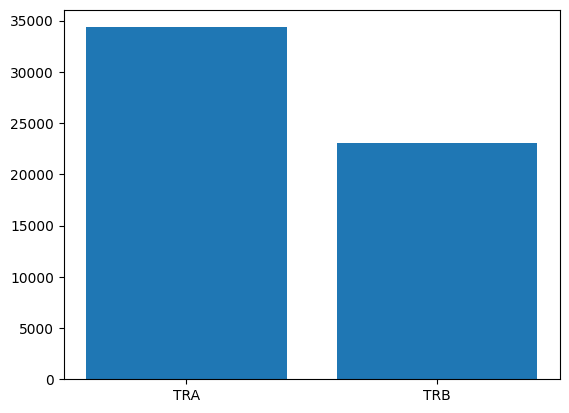

In [10]:
plt.bar(['TRA', 'TRB'], compl_df['type'].value_counts())

There is slight imbalance in the number of objects in the TRA and TRB classes, but probably it won't affect the model quality, because all the classes have enougth observations 

In [11]:
test_dataset = compl_df.sample(frac=0.30)
compl_df = compl_df.drop(test_dataset.index)
compl_df = compl_df.reset_index(drop=True)
compl_df.head()

,cdr3aa,type
0,C A E T R G A G N M L T F,0
1,C A V E D G Q K L L F,0
2,C A V S E P F G N E K L T F,0
3,C A F L N N A G N M L T F,0
4,C A V R D L W G S G G G A D G L T F,0


In [12]:
test_dataset = test_dataset.reset_index(drop=True)
ans = test_dataset['type']

test_dataset = test_dataset.drop(columns=['type'])



In [13]:
test_dataset.to_csv('data/ab_test_dataset.csv', index=False)
ans.to_csv('data/ab_ans.csv', index=False)

# TCR transformer model

In [14]:
tokeniz = BertTokenizer.from_pretrained("wukevin/tcr-bert", do_lower_case=False )

In [15]:
print(' Original: ', alpha_data.iloc[0, 0])
print('Tokenized: ', tokeniz.tokenize(compl_df.iloc[0, 0]))
print('Token IDs: ', tokeniz.convert_tokens_to_ids(tokeniz.tokenize(compl_df.iloc[0, 0])))

 Original:  CAETRGAGNMLTF
Tokenized:  ['C', 'A', 'E', 'T', 'R', 'G', 'A', 'G', 'N', 'M', 'L', 'T', 'F']
Token IDs:  [9, 13, 4, 6, 0, 11, 13, 11, 7, 17, 16, 6, 18]


In [16]:
max_len = 0
for seq in compl_df['cdr3aa']:
    input_ids = tokeniz.encode(seq, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max seq length: ', max_len)

Max seq length:  22


In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [18]:
my_model = CustomModel();
my_model.cuda()

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [19]:
input_ids, attention_masks, labels = my_model.tokenize(compl_df['cdr3aa'], compl_df['type']);

print('Original: ', compl_df.iloc[0, 0])
print('Token IDs:', input_ids[0])

/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  C A E T R G A G N M L T F
Token IDs: tensor([25,  9, 13,  4,  6,  0, 11, 13, 11,  7, 17, 16,  6, 18, 24, 21, 21, 21,
        21, 21, 21, 21])


In [20]:
train_dataset, val_dataset = my_model.split_data(input_ids, attention_masks, labels)

32,149 training samples
8,038 validation samples


In [21]:
my_model.fit(train_dataset, val_dataset)


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.01
  Training epcoh took: 0:01:33

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:01:31

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:01:31

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:05

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.00
  Training epcoh took: 0:01:31

Running Validation...
  Accuracy: 1.00
  Validation Loss: 0.00
  Validation took: 0:00:05

Training complete!


In [22]:
my_model.get_stats()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.006778,0.000973,0.999876,0:01:33,0:00:06
2,0.001910,0.000013,1.000000,0:01:31,0:00:05
3,0.001228,0.000014,1.000000,0:01:31,0:00:05
4,0.000124,0.000023,1.000000,0:01:31,0:00:05


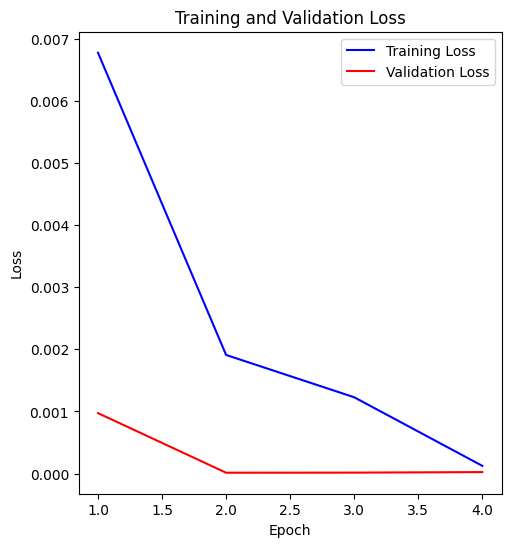

In [23]:
my_model.draw_stats_plot()

In [24]:
pred_labels = my_model.predict(test_dataset['cdr3aa'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
f1_sc = f1_score(ans, pred_labels)
print('Total f1_score: %.5f' % f1_sc)

Total f1_score: 0.99981


In [26]:
# save_model(my_model,"models/TCR_bert_ab.pth")
my_model_reload = load_model("models/TCR_bert_ab.pth", mod_type='TCR-bert', num_labels=2)

In [28]:
# Put both models to the same device
model=my_model.to("cpu")
model_reload=my_model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


In [18]:
my_model_reload.maximun_len = 25

In [19]:
my_model_reload.to(device)
pred_labels = my_model_reload.predict(test_dataset['cdr3aa'])
f1_sc = f1_score(ans, pred_labels)
print('Total f1_score: %.5f' % f1_sc)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Total f1_score: 0.99990


# ProtTrans model

In [29]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(compl_df, test_size=0.2, random_state=42)

In [30]:
train_df = train_df.rename({'cdr3aa': 'sequence', 'type': 'label'}, axis=1)
val_df = val_df.rename({'cdr3aa': 'sequence', 'type': 'label'}, axis=1)
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
val_df["sequence"]=val_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    
val_df

,sequence,label
33098,C A S S F G G Q G Y G Y T F,1
729,C A V T L S S G N T P L V F,0
13914,C I V R S R A S N F G N E K L T F,0
16831,C A S S L R D S H S G N T I Y F,1
625,C A V T Y T G G F K T I F,0
...,...,...
35663,C A S S Y Y G Q G D Q P Q H F,1
21335,C A S S P G G F N S P L H F,1
36687,C A S S M D R A N T E A F F,1
37266,C A S S F A G G G T D T Q Y F,1


In [33]:
tokenizer, model, history = train_per_protein(train_df, val_df, num_labels=2, batch=8, epochs=5, seed=42)

In [59]:
from models_mdf import load_model_, save_model
# save_model(Prottrans,"models/Prottrans_ab.pth")

tokenizer, Prottrans = load_model_("models/Prottrans_ab.pth", num_labels=2, mixed=False)

In [55]:
my_test=test_dataset.rename({'cdr3aa': 'sequence'}, axis=1)
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

my_test.head(5)

,sequence
0,C A S S L A G A G P Y N E Q F F
1,C A S S F Q G T S S Y Y T F
2,C A I G I A G G N E Q F F
3,C A S S L A A S G G R Y T Q Y F
4,C A L A S Y G N N R L A F


In [56]:
from tqdm import tqdm

In [57]:
#Use reloaded model
model = Prottrans

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# create Dataset
test_set=create_dataset(tokenizer, list(my_test['sequence']),list(ans))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 2153/2153 [02:33<00:00, 14.00it/s]


In [58]:
predictions= [item.argmax() for item in np.array(predictions)]
print("F1 score: ", f1_score(list(ans), predictions))

F1 score:  0.9996598804722804
